In [1]:
import torch
from matplotlib import pyplot as plt
from utils import *
from trainer import Trainer
from evaluator import Evaluator

%matplotlib inline
%load_ext autoreload
%autoreload 2

Iter 1/1000 - Loss: 1.333
Iter 2/1000 - Loss: 1.281
Iter 3/1000 - Loss: 1.238
Iter 4/1000 - Loss: 1.175
Iter 5/1000 - Loss: 1.124
Iter 6/1000 - Loss: 1.076
Iter 7/1000 - Loss: 1.033
Iter 8/1000 - Loss: 0.992
Iter 9/1000 - Loss: 0.948
Iter 10/1000 - Loss: 0.920
Iter 11/1000 - Loss: 0.883
Iter 12/1000 - Loss: 0.844
Iter 13/1000 - Loss: 0.826
Iter 14/1000 - Loss: 0.787
Iter 15/1000 - Loss: 0.747
Iter 16/1000 - Loss: 0.718
Iter 17/1000 - Loss: 0.685
Iter 18/1000 - Loss: 0.672
Iter 19/1000 - Loss: 0.643
Iter 20/1000 - Loss: 0.606
Iter 21/1000 - Loss: 0.590
Iter 22/1000 - Loss: 0.567
Iter 23/1000 - Loss: 0.568
Iter 24/1000 - Loss: 0.545
Iter 25/1000 - Loss: 0.541
Iter 26/1000 - Loss: 0.538
Iter 27/1000 - Loss: 0.537
Iter 28/1000 - Loss: 0.513
Iter 29/1000 - Loss: 0.521
Iter 30/1000 - Loss: 0.535
Iter 31/1000 - Loss: 0.506
Iter 32/1000 - Loss: 0.513
Iter 33/1000 - Loss: 0.495
Iter 34/1000 - Loss: 0.498
Iter 35/1000 - Loss: 0.493
Iter 36/1000 - Loss: 0.504
Iter 37/1000 - Loss: 0.502
Iter 38/10

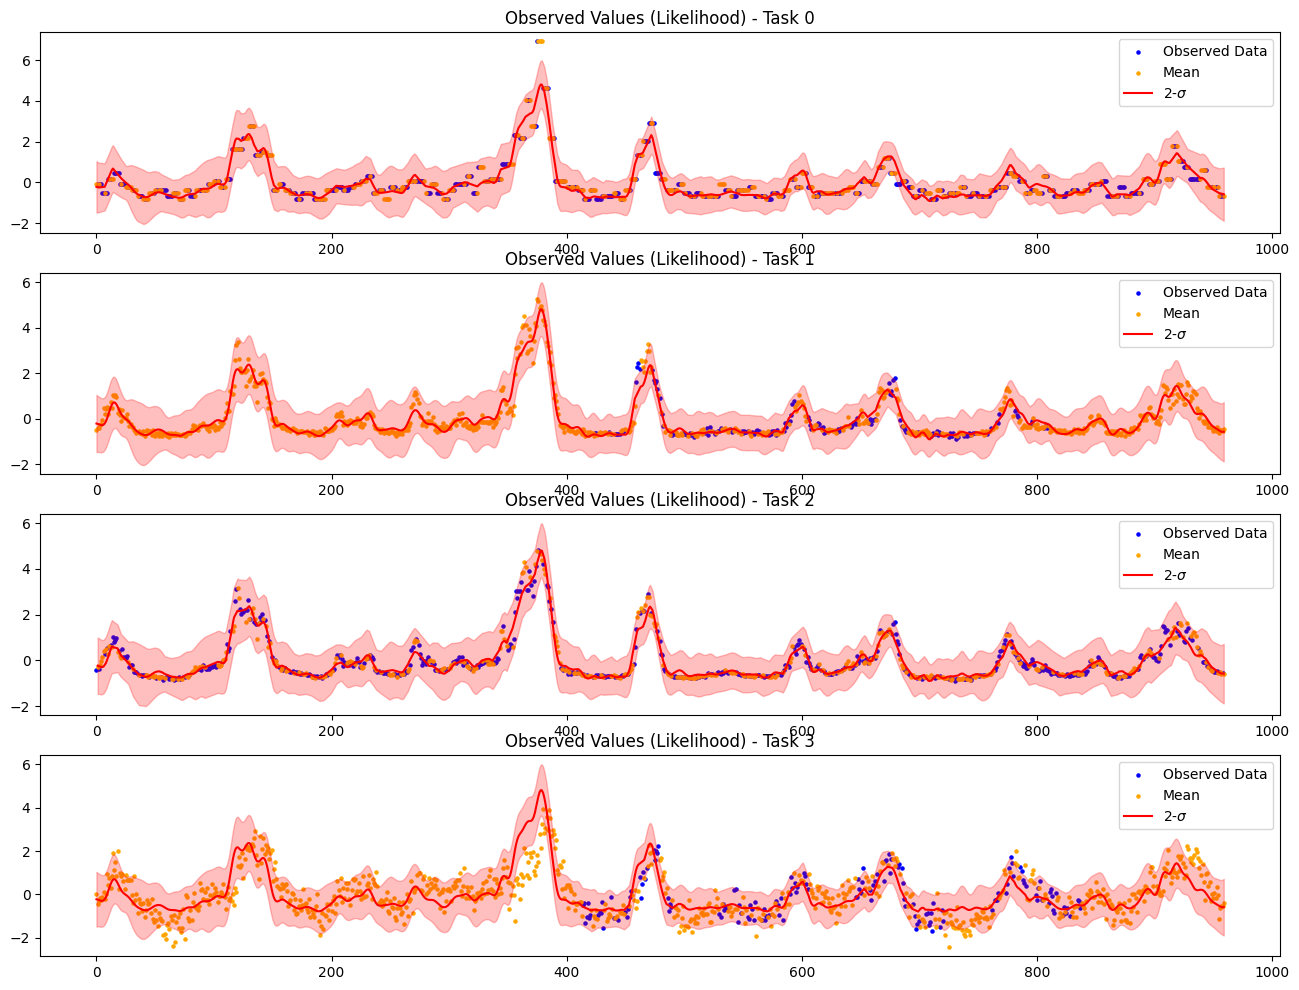

In [2]:
data = get_dataset('sgra')
keys = ["X", 'NIR', "IR", "submm"]
num_keys = len(keys)
iterations = 1000
max_early_stop = 30

for sample in data:
    train_x, train_idx, train_y, test_x, test_y, test_idx = process_data(sample, keys)

    # Concatenate the data for training
    full_train_x = torch.cat(train_x)
    full_train_idx = torch.cat(train_idx)
    full_train_y = torch.cat(train_y)

    trainer = Trainer(full_train_x, full_train_idx, full_train_y, 'gaussian', iterations=iterations, max_early_stop=max_early_stop)
    model, likelihood = trainer.train_model()

    evaluator = Evaluator(model, likelihood, test_x, test_idx, num_keys)

    observed_preds = evaluator.evaluate()

    # Initialize plots
    f, axes = plt.subplots(num_keys, 1, figsize=(num_keys * 4, num_keys * 3))

    if num_keys == 1:
        axes = [axes]

    # Plot the results and calculate metrics for all tasks
    mse = 0
    crps = 0
    for i in range(num_keys):
        # Send arrays to numpy
        ax = axes[i]
        train_xi = train_x[i].detach().numpy()
        train_yi = train_y[i].detach().numpy()
        test_xi = test_x[i].detach().numpy()
        test_yi = test_y[i].detach().numpy()

        # Separate predictions
        means = observed_preds[i].mean.cpu().detach().numpy()
        lower, upper = observed_preds[i].confidence_region()
        lower, upper = lower.detach().cpu().numpy(), upper.cpu().detach().numpy()
        standard_deviations = (upper - means) / 2.0 # Because upper and lower correspond to 2 std's

        ax_plot(ax, train_yi, train_xi, test_yi, test_xi, means, lower, upper, f'Observed Values (Likelihood) - Task {i}')

        # Calculate metrics
        crps += crps_norm(test_yi, means, standard_deviations)
        mse += mean_squared_error(test_yi, means)

    print('Average mse is: ', mse / num_keys)
    print('Average CRPS is: ', crps / num_keys)

    # Show the plot
    plt.show()

    break

